In [1]:
import pandas as pd
import numpy as np

chess_0119 = pd.read_csv("data/standard_1901.csv", sep='|')

In [4]:
chess_0119.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325205 entries, 0 to 325204
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ID Number  325205 non-null  int64 
 1   Name       325205 non-null  object
 2   Fed        325205 non-null  object
 3   Sex        325205 non-null  object
 4   Tit        18430 non-null   object
 5   WTit       3700 non-null    object
 6   OTit       4980 non-null    object
 7   FOA        1513 non-null    object
 8   Rat        325205 non-null  int64 
 9   Gms        325205 non-null  int64 
 10  K          325205 non-null  int64 
 11  B-day      325205 non-null  int64 
 12  Flag       174473 non-null  object
 13  Year       325205 non-null  int64 
 14  Mon        325205 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 37.2+ MB


In [5]:
#lowercase column names
chess_0119.columns = chess_0119.columns.str.lower()

In [6]:
#check for duplicated rows
sum(chess_0119.duplicated(subset=['id number', 'name', 'fed', 'sex', 'tit', 'wtit', 'otit', 'foa', 'rat',
       'gms', 'k', 'b-day', 'flag', 'year', 'mon']))

0

In [7]:
#check the percentage of missing values
percent_missing = chess_0119.isna().sum() * 100 / len(chess_0119)
missing_value_df = pd.DataFrame({'column_name': chess_0119.columns,
                                 'percent_missing': percent_missing})
missing_value_df

,column_name,percent_missing
id number,id number,0.000000
name,name,0.000000
fed,fed,0.000000
sex,sex,0.000000
tit,tit,94.332805
wtit,wtit,98.862256
otit,otit,98.468658
foa,foa,99.534755
rat,rat,0.000000
gms,gms,0.000000


In [8]:
#share of zeros
print('cols')
print(chess_0119[chess_0119 == 0].count(axis=0)/len(chess_0119.index))

cols
id number    0.000000
name         0.000000
fed          0.000000
sex          0.000000
tit          0.000000
wtit         0.000000
otit         0.000000
foa          0.000000
rat          0.000000
gms          0.831027
k            0.000000
b-day        0.026912
flag         0.000000
year         0.000000
mon          0.000000
dtype: float64


In [9]:
#replace zeros in b-day by median value
chess_0119['b-day'].replace(to_replace = 0, value = chess_0119['b-day'].median(), inplace=True)

In [12]:
#construct target columns
month1 = pd.read_csv('data/standard_1901.csv', sep='|', dtype={'FOA': 'str', 'B-day': 'str', 'Rat': 'str'})
month2 = pd.read_csv('data/standard_1902.csv', sep='|', dtype={'FOA': 'str', 'B-day': 'str', 'Rat': 'str'})
month1.columns = month1.columns.str.lower()
month2.columns = month2.columns.str.lower()
month1['rat'] = month1['rat'].str.replace('M ', '')
month1['rat'] = month1['rat'].astype('int64')
month2['rat'] = month2['rat'].str.replace('M ', '')
month2['rat'] = month2['rat'].astype('int64')
month1['b-day'] = month1['b-day'].astype('int64')
month2['b-day'] = month2['b-day'].astype('int64')
month1['b-day'].replace(to_replace = 0, value = month1['b-day'].median(), inplace=True)
month2['b-day'].replace(to_replace = 0, value = month2['b-day'].median(), inplace=True)
prev_rating = month1[['id number', 'rat']]
prev_rating = prev_rating.rename(columns={"rat": "prevrat"})
month2 = pd.merge(month2, prev_rating, how='left', sort=False)
month2['prevrat'] = month2['prevrat'].fillna(month2['rat'])
month2['ratdiff'] = month2['rat'] - month2['prevrat']
month2['ratchg'] = np.where(month2['ratdiff'] == 0, 0, np.where(month2['ratdiff'] >  0, 1, 2))

In [13]:
#construct "age" column from year and b-day
month2['age'] = month2['year'] - month2['b-day']
month2 = month2.drop(columns=['prevrat', 'name', 'b-day'], axis=1)

In [14]:
#divide dataset to men amd women
women = month2.loc[month2['sex'] == 'F']
men = month2.loc[month2['sex'] == 'M']

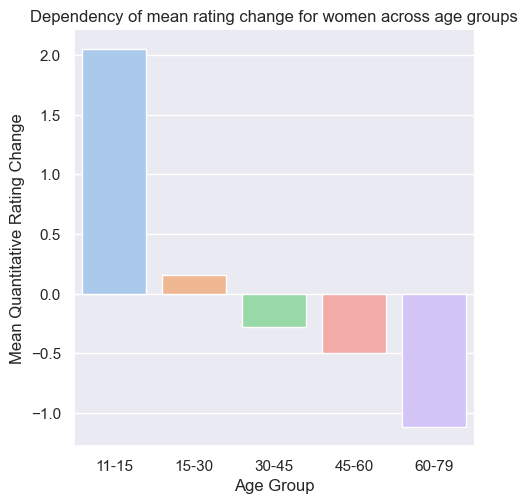

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

group_age_women = women.groupby(pd.cut(month2['age'], 
                  bins=[11,15,30,45,60,79],  
                  labels=['11-15', '15-30', '30-45', '45-60', '60-79']))['ratdiff'].mean().reset_index()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.set(font_scale=1)
sns.set_palette('pastel')
g = sns.catplot(data=group_age_women, x='age', y='ratdiff', kind='bar', errorbar=None).set(title='Dependency of mean rating change for women across age groups') #title='Distribution of rating among development score types')
g.set_xlabels('Age Group')
g.set_ylabels('Mean Quantitative Rating Change')

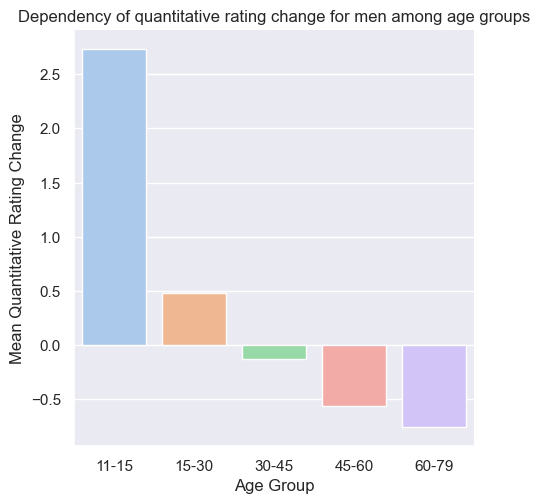

In [19]:
group_age_men = men.groupby(pd.cut(month2['age'], 
                  bins=[11,15,30,45,60,79],  
                  labels=['11-15', '15-30', '30-45', '45-60', '60-79']))['ratdiff'].mean().reset_index()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.set(font_scale=1)
sns.set_palette('pastel')
g = sns.catplot(data=group_age_men, x='age', y='ratdiff', kind='bar', errorbar=None).set(title='Dependency of quantitative rating change for men among age groups') #title='Distribution of rating among development score types')
g.set_xlabels('Age Group')
g.set_ylabels('Mean Quantitative Rating Change')

In [17]:
#get rid of outliers
month2.loc[month2['age']>79,'age'] = month2['age'].median()
month2.loc[month2['age']<11,'age'] = month2['age'].median()

C:\Users\lack_\AppData\Local\Temp\ipykernel_1888\1370486624.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = month2.corr()


<AxesSubplot: >

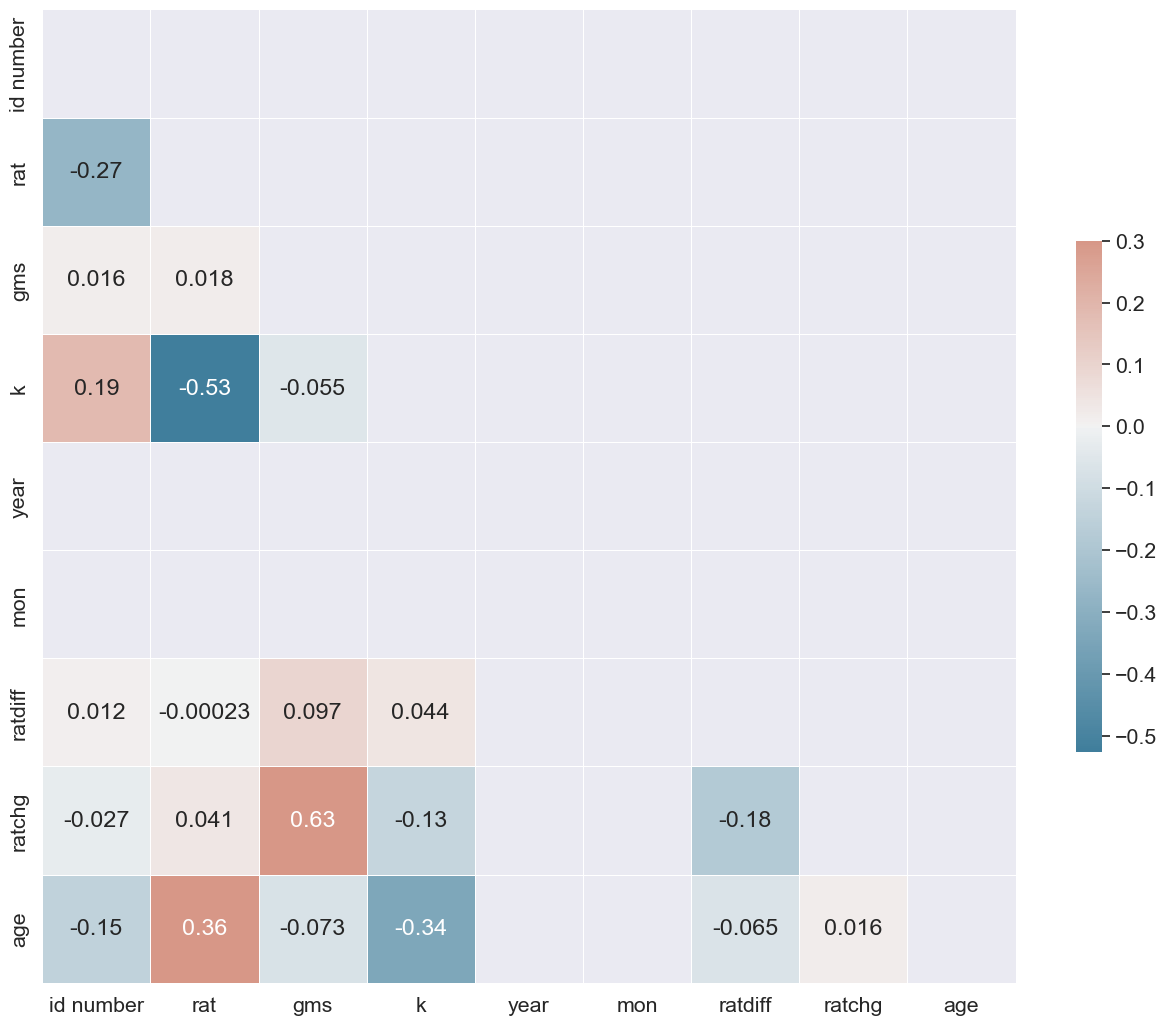

In [21]:
# correlation matrix
corr = month2.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.set(rc={'figure.figsize':(15.7,13.27)})
sns.set(font_scale=1.4)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

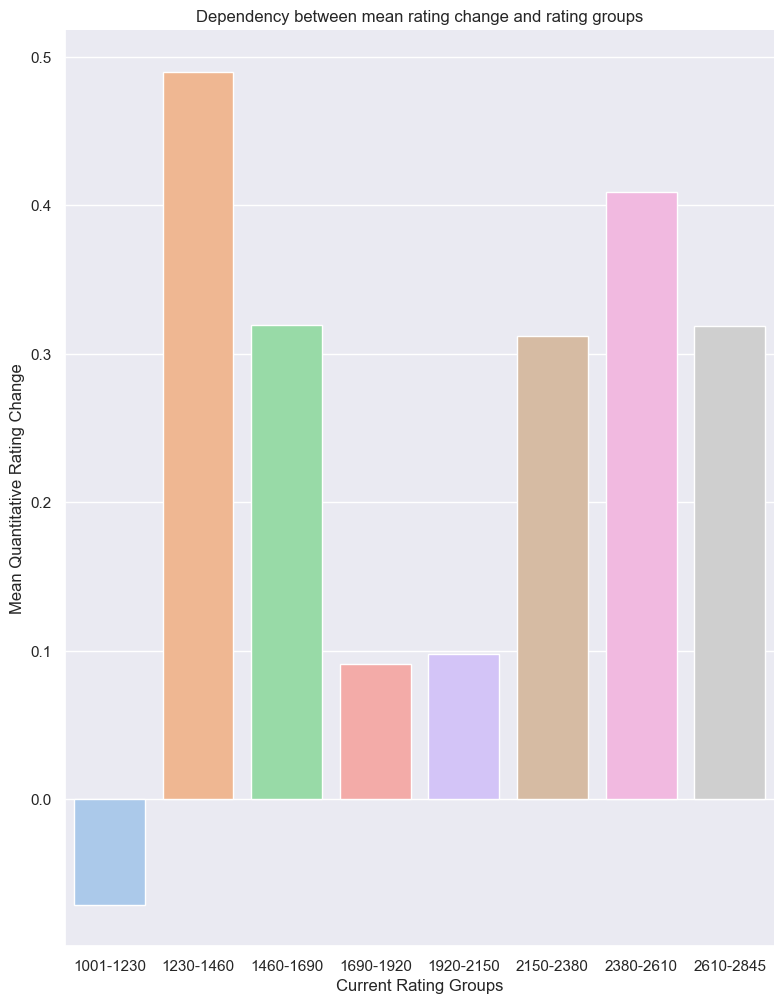

In [24]:
group_rat = month2.groupby(pd.cut(month2['rat'], 
                  bins=[1001,1230,1460,1690,1920,2150,2380,2610,2845],  
                  labels=['1001-1230', '1230-1460', '1460-1690', '1690-1920', '1920-2150', '2150-2380', '2380-2610', '2610-2845']))['ratdiff'].mean().reset_index()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.set(font_scale=1)
sns.set_palette('pastel')
g = sns.catplot(data=group_rat, x='rat', y='ratdiff', kind='bar',  height=10, aspect=.8, errorbar=None).set(title='Dependency between mean rating change and rating groups') #title='Distribution of rating among development score types')
g.set_xlabels('Current Rating Groups')
g.set_ylabels('Mean Quantitative Rating Change')

In [26]:
#get rid of missing values
month2['tit'] = month2['tit'].fillna('NT')

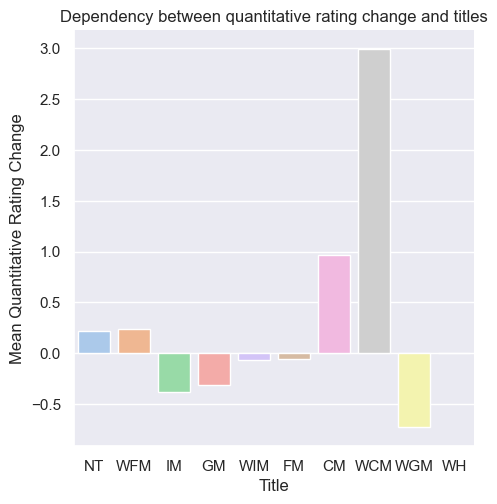

In [27]:
month2.groupby('tit').agg(rating=('ratdiff', 'mean'))
g = sns.catplot(data=month2, x='tit', y='ratdiff', kind='bar', errorbar=None).set(title='Dependency between quantitative rating change and titles') #title='Distribution of rating among development score types')
g.set_xlabels('Title')
g.set_ylabels('Mean Quantitative Rating Change')

In [28]:
#get rid of missing values
month2['foa'] = month2['foa'].fillna('NT')

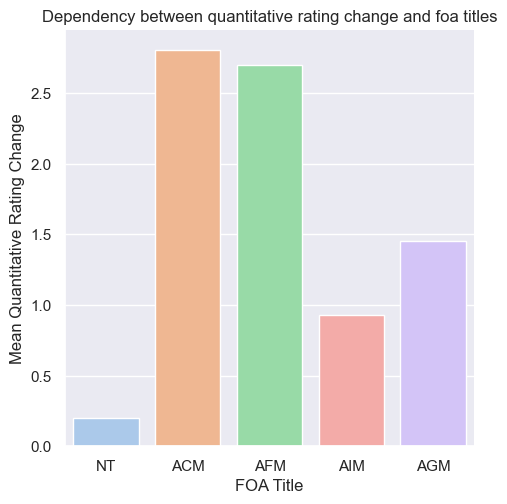

In [29]:
month2.groupby('foa').agg(rating=('ratdiff', 'mean'))
g = sns.catplot(data=month2, x='foa', y='ratdiff', kind='bar', errorbar=None).set(title='Dependency between quantitative rating change and foa titles') #title='Distribution of rating among development score types')
g.set_xlabels('FOA Title')
g.set_ylabels('Mean Quantitative Rating Change')

In [30]:
month2.groupby('fed', as_index=True)['ratdiff'].mean().sort_values().tail(5)

fed
NZL    1.139013
MGL    1.158491
NCA    1.191136
MNC    1.661765
SOM    2.000000
Name: ratdiff, dtype: float64

In [31]:
month2.groupby('fed', as_index=True)['ratdiff'].mean().sort_values().head(5)

fed
FIJ   -3.906977
SSD   -3.466667
SEY   -3.444444
BDI   -2.363636
AFG   -2.287500
Name: ratdiff, dtype: float64